In [1]:
# upgrade in command line for specific interpreter

import sys
sys.executable
# /Users/lianfeng/Document/species_richness_sdm/venv/bin/pip install --upgrade tensorflow

'/Users/lianfeng/Document/species_richness_sdm/venv/bin/python'

In [84]:
from __future__ import absolute_import, division, print_function, unicode_literals

import datetime
import pathlib
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0


In [85]:
# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs
    
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorboard.plugins.hparams import api as hp

#### Get the data from PG 

In [86]:
localhost = {'user': 'postgres', 'password': 'postgres', 'host': 'localhost', 'port': 5432, 'db': 'fiadb'}
params = 'postgresql://{0}:{1}@{2}:{3}/{4}'
engine = create_engine(params.format(localhost['user'], localhost['password'], localhost['host'], localhost['port'], localhost['db']))
# geom_sql = """select distinct grid_id, grid_geom from fs_fiadb.pergrid"""
pergrid_base = """select distinct * from predictor.pergrid_base"""
pergrid_base_df = pd.read_sql(pergrid_base, engine)
print(pergrid_base_df.shape)
pergrid_base_df_na_remove = pergrid_base_df.dropna()
print(pergrid_base_df_na_remove.shape)

(15310, 22)
(13503, 22)


In [87]:
pergrid_base_encoded=pd.get_dummies(pergrid_base_df_na_remove, columns=["hydrogroup"])

In [88]:
pergrid_base_encoded.columns

Index(['grid_id', 'aet', 'ai', 'art', 'ewd', 'fa', 'map', 'mat', 'mpdq',
       'mtcq', 'pet', 'psn', 'ra', 'rmap', 'rmat', 'tsn', 'mfdf', 'alt',
       'mtwq', 'wkb_geometry', 'tsr', 'hydrogroup_A', 'hydrogroup_A/D',
       'hydrogroup_B', 'hydrogroup_B/D', 'hydrogroup_C', 'hydrogroup_C/D',
       'hydrogroup_D'],
      dtype='object')

In [98]:
pred_var= ['aet', 'ai', 'art', 'ewd', 'fa', 'map', 'mat', 'mpdq',
       'mtcq', 'pet', 'psn', 'ra', 'rmap', 'rmat', 'tsn', 'mfdf', 'alt',
       'mtwq','hydrogroup_A', 'hydrogroup_A/D',
       'hydrogroup_B', 'hydrogroup_B/D', 'hydrogroup_C', 'hydrogroup_C/D',
       'hydrogroup_D']

In [99]:
X = pergrid_base_encoded[pred_var]

# standarize predictors
ss = StandardScaler(with_mean=False, with_std=False)
X_std = ss.fit_transform(X.values)

Xstd=pd.DataFrame(data=X_std[0:,0:],
                index=X.index,
                columns=pred_var)
y_true = pergrid_base_encoded['tsr']

In [100]:
X_train, X_test, y_train, y_test = train_test_split(Xstd, y_true, test_size=0.2, shuffle=True)

In [111]:
y_test

5438     28.0
8405     17.0
2757     34.0
3253     20.0
5835      9.0
         ... 
4618      1.0
3176     33.0
8452     37.0
9369     23.0
13600    23.0
Name: tsr, Length: 2701, dtype: float64

In [96]:
len(train_dataset.keys())

25

In [97]:
train_dataset.columns

Index(['aet', 'ai', 'art', 'ewd', 'fa', 'map', 'mat', 'mpdq', 'mtcq', 'pet',
       'psn', 'ra', 'rmap', 'rmat', 'tsn', 'mfdf', 'alt', 'mtwq',
       'hydrogroup_A', 'hydrogroup_A/D', 'hydrogroup_B', 'hydrogroup_B/D',
       'hydrogroup_C', 'hydrogroup_C/D', 'hydrogroup_D'],
      dtype='object')

### Build the model
`Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value.

#### When training with Keras's Model.fit(), adding the tf.keras.callbacks.TensorBoard callback ensures that logs are created and stored. Additionally, enable histogram computation every epoch with histogram_freq=1 (this is off by default)
Place the logs in a timestamped subdirectory to allow easy selection of different training runs.

### Train the model and tune hyperparameters

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

Use an EarlyStopping callback that tests a training condition for every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

In [112]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([500, 1000, 2000, 3000]))
# HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2,)) # units to drop rate
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam']))
METRIC_ACCURACY = 'mean_absolute_error'

In [113]:
EPOCHS = 500

# Load the TensorBoard notebook extension
# %load_ext tensorboard

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
log_dir = "logs/M5_base_fnn_tensorflow/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

def train_test_model(hparams):
  model = keras.Sequential([
    layers.Dense(hparams[HP_NUM_UNITS], activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(hparams[HP_NUM_UNITS], activation='relu'),
    layers.Dense(hparams[HP_NUM_UNITS], activation='relu'),
#     layers.Dropout(hparams[HP_DROPOUT]),
    layers.Dense(1, activation='linear')
  ])

  model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='mae',
      metrics=['mean_absolute_error']
  )

  model.fit(x=X_train, 
            y=y_train, 
            epochs=EPOCHS, 
            validation_split = 0.2, 
            verbose=0, 
            callbacks=[tfdocs.modeling.EpochDots(), early_stop, tensorboard_callback])
  _, mean_absolute_error = model.evaluate(X_test, y_test)

  return mean_absolute_error

In [114]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    mean_absolute_error = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, mean_absolute_error, step=10)

In [115]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
        hparams = {
          HP_NUM_UNITS: num_units,
#           HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('logs/M5_base_fnn_tensorflow/' + run_name, hparams)
        session_num += 1

--- Starting trial: run-0
{'num_units': 500, 'optimizer': 'adam'}

Epoch: 0, loss:6661.1744,  mean_absolute_error:6661.1797,  val_loss:632.2912,  val_mean_absolute_error:632.2911,  
2701/2701 [==============================] - 0s 40us/sample - loss: 11.5361 - mean_absolute_error: 11.5360
--- Starting trial: run-1
{'num_units': 500, 'optimizer': 'adam'}

Epoch: 0, loss:7023.6753,  mean_absolute_error:7023.6748,  val_loss:17.1269,  val_mean_absolute_error:17.1269,  
2701/2701 [==============================] - 0s 50us/sample - loss: 11.5076 - mean_absolute_error: 11.5076
--- Starting trial: run-2
{'num_units': 1000, 'optimizer': 'adam'}

Epoch: 0, loss:7282.5054,  mean_absolute_error:7282.5039,  val_loss:16.8456,  val_mean_absolute_error:16.8456,  
2701/2701 [==============================] - 0s 82us/sample - loss: 11.6173 - mean_absolute_error: 11.6173
--- Starting trial: run-3
{'num_units': 1000, 'optimizer': 'adam'}

Epoch: 0, loss:7173.1149,  mean_absolute_error:7173.1177,  val_loss:

In [47]:
%tensorboard --logdir log_dir

Reusing TensorBoard on port 6006 (pid 48660), started 1:50:05 ago. (Use '!kill 48660' to kill it.)

### Make predictions

Finally, predict TSR values using data in the testing set:

In [ ]:
def train_test_model(hparams):
  model = keras.Sequential([
    layers.Dense(hparams[HP_NUM_UNITS], activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dropout(hparams[HP_DROPOUT]),
    layers.Dense(hparams[HP_NUM_UNITS], activation='relu'),
    layers.Dropout(hparams[HP_DROPOUT]),
    layers.Dense(hparams[HP_NUM_UNITS], activation='relu'),
    layers.Dropout(hparams[HP_DROPOUT]),
    layers.Dense(1, activation='linear')
  ])


In [26]:
best_model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='linear')
])

best_model.compile(
    optimizer='adagrad',
    loss='mae',
    metrics=['mean_absolute_error']
)

best_model.fit(x=normed_train_data, 
        y=train_labels, 
        epochs=EPOCHS, 
        validation_split = 0.2, 
        verbose=0, 
        callbacks=[tfdocs.modeling.EpochDots(), early_stop, tensorboard_callback])


Epoch: 0, loss:5.3133,  mean_absolute_error:5.3133,  val_loss:4.2593,  val_mean_absolute_error:4.2593,  
....................................................................................................
Epoch: 100, loss:3.3962,  mean_absolute_error:3.3962,  val_loss:3.3564,  val_mean_absolute_error:3.3564,  
....................................................................................................
Epoch: 200, loss:3.3190,  mean_absolute_error:3.3190,  val_loss:3.3038,  val_mean_absolute_error:3.3038,  
..............

In [27]:
test_predictions = best_model.predict(normed_test_data).flatten()

It looks like our model predicts reasonably well. Let's take a look at the error distribution.

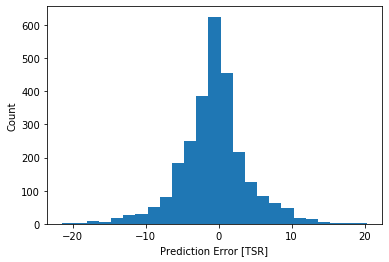

In [28]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [TSR]")
_ = plt.ylabel("Count")

### Make TSR predictions using the full dataset

In [29]:
# test_predictions = model.predict(normed_test_data).flatten()
y_pred = best_model.predict(normed_dataset).flatten()

### Ingest TSR predictions to PG

In [31]:
pergrid_all_predicted = pd.DataFrame(
    {'grid_id': grid_id,
     'tsr': full_labels,
     'tsr_predicted': y_pred})

In [32]:
pergrid_all_predicted.to_sql(name='m5_base_fnn_tensorflow', con=engine, schema='predictor', if_exists='replace', index=False)

In [33]:
update_geom = """
alter table predictor.m5_base_fnn_tensorflow add column if not exists wkb_geometry geometry(Polygon,4269);
update predictor.m5_base_fnn_tensorflow A SET wkb_geometry = B.wkb_geometry
FROM predictor.pergrid_base B
WHERE A.grid_id = B.grid_id
"""

In [34]:
connection = engine.connect()
connection.execute(update_geom)

In [35]:
update_residual = """
alter table predictor.m5_base_fnn_tensorflow add column residual double precision;
update predictor.m5_base_fnn_tensorflow set residual = (tsr_predicted-tsr);
"""

In [36]:
connection = engine.connect()
connection.execute(update_residual)